In [1]:
import numpy as np
import os
import pandas as pd
import tables as tb
import matplotlib.pyplot as plt
import matplotlib         as mpl
import matplotlib.pyplot  as plt
from mpl_toolkits.mplot3d import Axes3D
from invisible_cities.io import mcinfo_io as mio
from scipy import stats
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

## Multi-run analysis

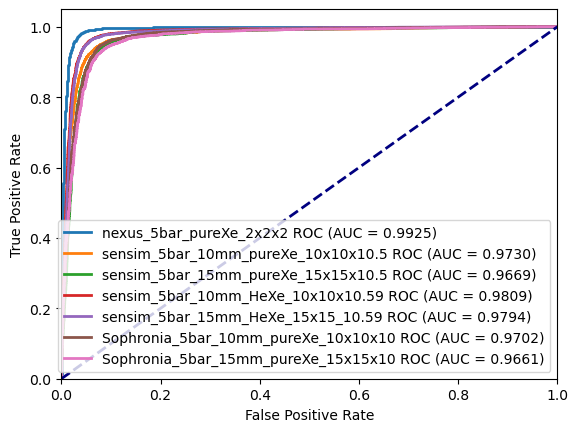

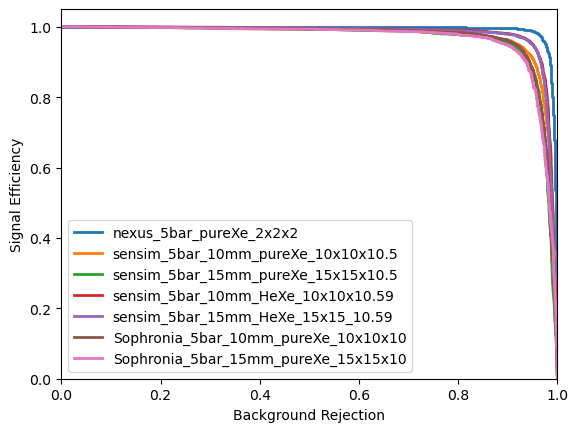

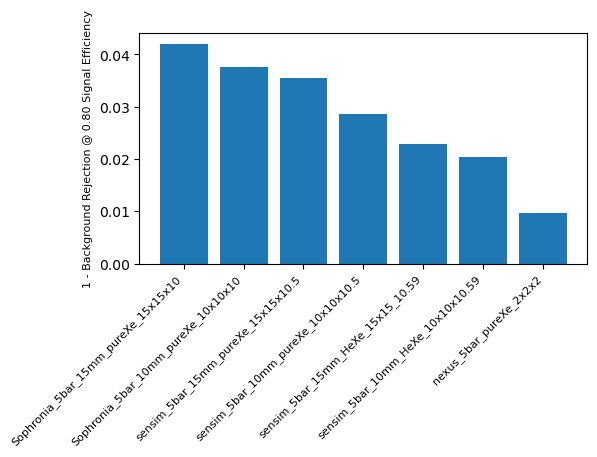

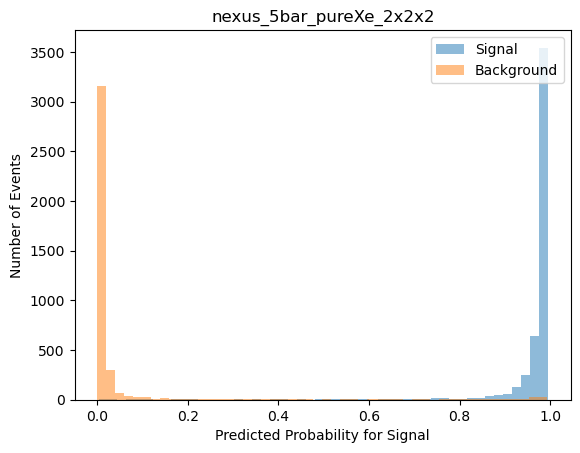

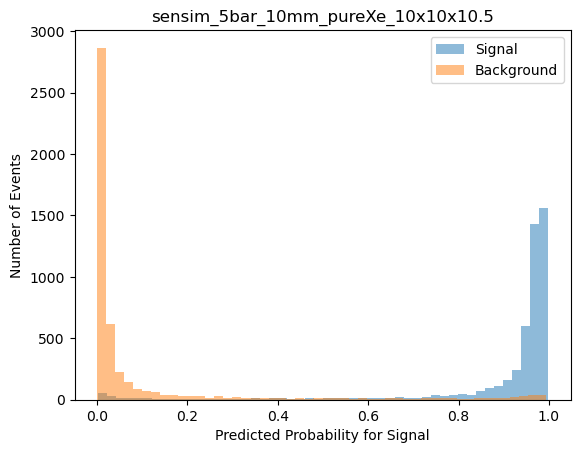

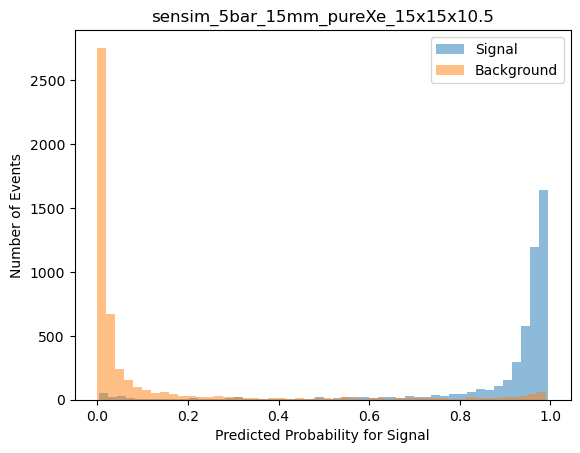

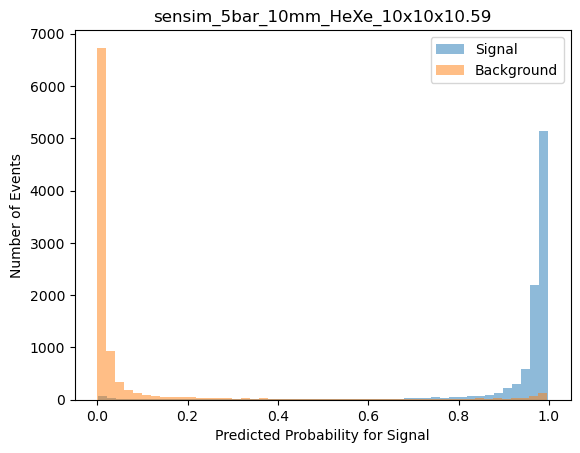

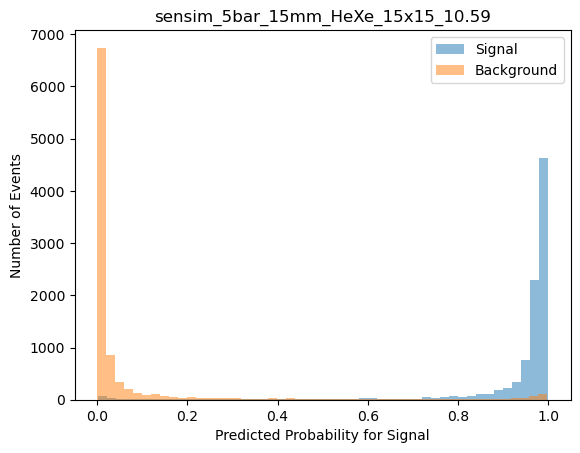

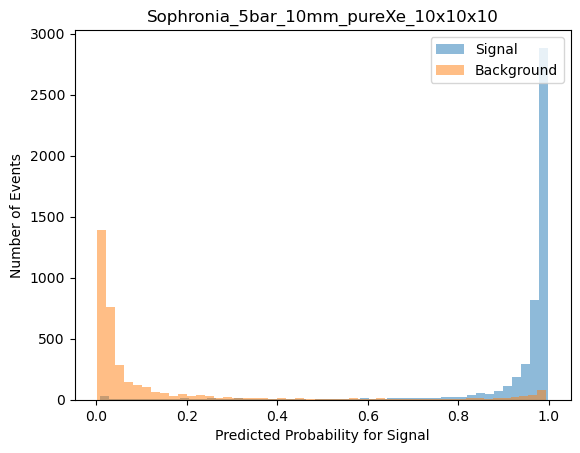

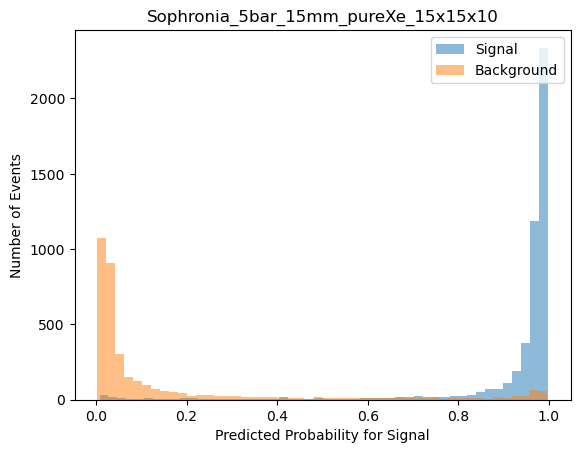

In [23]:
# Ensure the 'plt/' directory exists
os.makedirs("plt", exist_ok=True)

# Load data from a single file
def load_data(filename):
    with tb.open_file(filename, 'r') as h5file:
        data = h5file.root.DATASET.EventPred[:]
        true_labels = data['label']
        probabilities_signal = data['class_1']
        probabilities_background = data['class_0']
    return true_labels, probabilities_signal, probabilities_background

# Interpolation function for more precise values
def interpolate_signal_efficiency(fpr, tpr, eff_eval):
    """Interpolates to find the background rejection for a given signal efficiency."""
    if eff_eval < tpr[0] or eff_eval > tpr[-1]:
        raise ValueError("eff_eval must lie within the range of tpr values.")
    return np.interp(eff_eval, tpr, 1 - fpr)

# Plot ROC curves for multiple runs
def plot_roc_curves(datasets, names):
    plt.figure()
    for dataset, name in zip(datasets, names):
        true_labels, probabilities_signal, _ = dataset
        fpr, tpr, _ = roc_curve(true_labels, probabilities_signal)
        roc_auc = auc(fpr, tpr)
        np.savetxt(f"plt/ROC_{name}.dat", np.column_stack((fpr, tpr)),
                   header=f"False Positive Rate\tTrue Positive Rate (AUC = {roc_auc:.4f})", fmt="%.5f")
        plt.plot(fpr, tpr, lw=2, label=f'{name} ROC (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.savefig("plt/comparative_roc_curves.pdf")
    #plt.close()

# Plot signal efficiency vs. background rejection for multiple runs
def plot_signal_vs_background(datasets, names, eff_eval):
    plt.figure()
    eff_rejections = []
    for dataset, name in zip(datasets, names):
        true_labels, probabilities_signal, _ = dataset
        fpr, tpr, thresholds = roc_curve(true_labels, probabilities_signal)
        background_rejection = 1 - fpr
        np.savetxt(f"plt/signal_vs_background_{name}.dat", np.column_stack((background_rejection, tpr)),
                   header="Background Rejection\tSignal Efficiency", fmt="%.5f")
        plt.plot(background_rejection, tpr, lw=2, label=f'{name}')
        # Interpolate background rejection for the given signal efficiency
        rejection_at_eff_eval = interpolate_signal_efficiency(fpr, tpr, eff_eval)
        eff_rejections.append((name, 1 - rejection_at_eff_eval))
    plt.xlabel('Background Rejection')
    plt.ylabel('Signal Efficiency')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower left")
    plt.savefig("plt/comparative_signal_vs_background.pdf")
    #plt.close()

    # Plot (1 - background rejection) vs. dataset names for the specified signal efficiency
    eff_rejections = sorted(eff_rejections, key=lambda x: x[1], reverse=True)
    names_sorted, rejections_sorted = zip(*eff_rejections)
    plt.figure()
    plt.bar(names_sorted, rejections_sorted)
    plt.subplots_adjust(left=0.2)
    plt.subplots_adjust(bottom=0.4)
    plt.ylabel(f'1 - Background Rejection @ {eff_eval:.2f} Signal Efficiency',fontsize=8)
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.savefig("plt/efficiency_vs_dataset.pdf")
    #plt.close()

# Plot confusion matrices for multiple runs and save as PDFs
def plot_confusion_matrices(datasets, names, threshold=0.5):
    for dataset, name in zip(datasets, names):
        plt_filename = f"plt/confusion_matrix_{name}.png"
        true_labels, probabilities_signal, _ = dataset
        predicted_labels = (probabilities_signal >= threshold).astype(int)
        cm = confusion_matrix(true_labels, predicted_labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Background', 'Signal'])
        disp.plot(cmap=plt.cm.Blues, values_format='d')
        plt.subplots_adjust(left=0.2)
        plt.title(f'{name} Confusion Matrix (Threshold = {threshold})',fontsize=10)
        plt.savefig(plt_filename)
        plt.close()

# Plot histograms for signal and background probabilities and save as PDFs
def plot_probability_histograms(datasets, names):
    pdf_filename = "plt/probability_histograms.pdf"
    from matplotlib.backends.backend_pdf import PdfPages
    with PdfPages(pdf_filename) as pdf:
        for dataset, name in zip(datasets, names):
            true_labels, probabilities_signal, _ = dataset
            plt.figure()
            plt.hist(probabilities_signal[true_labels == 1], bins=50, alpha=0.5, label='Signal')
            plt.hist(probabilities_signal[true_labels == 0], bins=50, alpha=0.5, label='Background')
            plt.xlabel('Predicted Probability for Signal')
            plt.ylabel('Number of Events')
            plt.legend(loc='upper right')
            plt.title(name)
            pdf.savefig()
            #plt.close()

# Main function to compare multiple training runs
def compare_multiple_runs(filenames, names, eff_eval=0.8):
    datasets = [load_data(filename) for filename in filenames]

    # Plot and save ROC curves
    plot_roc_curves(datasets, names)

    # Plot and save signal efficiency vs. background rejection
    plot_signal_vs_background(datasets, names, eff_eval)

    # Plot and save confusion matrices
    plot_confusion_matrices(datasets, names)

    # Plot and save probability histograms
    plot_probability_histograms(datasets, names)

# 5 bar
filenames = [
    '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_nexus_2x2x2/tst_file_NEXT100_epoch19.h5',
    '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_10mm/tst_file_NEXT100_sensim_10mm.h5',
    '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_15mm/tst_file_NEXT100_sensim_15mm.h5',
    '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_HeXe_10mm/tst_file_NEXT100_sensim_HeXe_10mm.h5',
    '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_HeXe_15mm/tst_file_NEXT100_sensim_HeXe_15mm.h5',
    '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Sophronia_10mm_10x10x10/tst_file_NEXT100_Sophronia_10mm_10x10x10.h5',
    '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Sophronia_15mm_15x15x10/tst_file_NEXT100_Sophronia_15mm_15x15x10.h5'
    
]
names = [
    "nexus_5bar_pureXe_2x2x2",
    "sensim_5bar_10mm_pureXe_10x10x10.5",
    "sensim_5bar_15mm_pureXe_15x15x10.5",
    "sensim_5bar_10mm_HeXe_10x10x10.59",
    "sensim_5bar_15mm_HeXe_15x15_10.59",
    "Sophronia_5bar_10mm_pureXe_10x10x10",
    "Sophronia_5bar_15mm_pureXe_15x15x10"
]

# 13 bar
# filenames = [
# #     '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_13bar_HeXe_10mm/tst_file_NEXT100_sensim_13bar_HeXe_10mm.h5',
# #     '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_13bar_15mm/tst_file_NEXT100_sensim_13bar_15mm.h5',
#     '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Sophronia_13bar_15mm_15x15x10/tst_file_NEXT100_Sophronia_15mm_15x15x10.h5'    
# ]
# names = [
# #     "sensim_13bar_10mm_HeXe_10x10x12.61",
# #     "sensim_13bar_15mm_15x15x13.51",
#     "Sophronia_13bar_15mm_pureXe_15x15x10"
# ]
eff_eval = 0.8
compare_multiple_runs(filenames, names, eff_eval)

### Analysis of two training runs

In [ ]:
# Load data from a single file
def load_data(filename):
    with tb.open_file(filename, 'r') as h5file:
        data = h5file.root.DATASET.EventPred[:]
        true_labels = data['label']
        probabilities_signal = data['class_1']
        probabilities_background = data['class_0']
    return true_labels, probabilities_signal, probabilities_background

# Plot ROC curves for two runs
def plot_comparative_roc_curve(true_labels_1, probabilities_signal_1, name_1, true_labels_2, probabilities_signal_2, name_2c, plot_both=True):
    fpr_1, tpr_1, _ = roc_curve(true_labels_1, probabilities_signal_1)
    roc_auc_1 = auc(fpr_1, tpr_1)

    fpr_2, tpr_2, _ = roc_curve(true_labels_2, probabilities_signal_2)
    roc_auc_2 = auc(fpr_2, tpr_2)
    
    # Save numerical values to .dat files
    np.savetxt(f"ROC_{name_1}.dat", np.column_stack((fpr_1, tpr_1)),
               header=f"False Positive Rate\tTrue Positive Rate (AUC = {roc_auc_1:.4f})", fmt="%.5f")

    if plot_both:
        np.savetxt(f"ROC_{name_2}.dat", np.column_stack((fpr_2, tpr_2)),
                   header=f"False Positive Rate\tTrue Positive Rate (AUC = {roc_auc_2:.4f})", fmt="%.5f")

    plt.figure()
    plt.plot(fpr_1, tpr_1, color='darkorange', lw=2, label=f'{name_1} ROC (AUC = {roc_auc_1:.4f})')
    if(plot_both): plt.plot(fpr_2, tpr_2, color='blue', lw=2, label=f'{name_2} ROC (AUC = {roc_auc_2:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title('Comparative ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

# Plot probability distributions for two runs
def plot_comparative_probability_distributions(true_labels_1, probabilities_signal_1, name_1, true_labels_2, probabilities_signal_2, name_2, plot_both=True):
    plt.figure()
    plt.hist(probabilities_signal_1[true_labels_1 == 1], bins=50, alpha=0.5, label=f'{name_1} Signal')
    plt.hist(probabilities_signal_1[true_labels_1 == 0], bins=50, alpha=0.5, label=f'{name_1} Background')
    if(plot_both): plt.hist(probabilities_signal_2[true_labels_2 == 1], bins=50, alpha=0.5, histtype='step', label=f'{name_2} Signal')
    if(plot_both): plt.hist(probabilities_signal_2[true_labels_2 == 0], bins=50, alpha=0.5, histtype='step', label=f'{name_2} Background')
    plt.xlabel('Predicted Probability for Signal')
    plt.ylabel('Number of Events')
    #plt.title('Comparative Probability Distributions')
    plt.legend(loc='upper right')
    plt.show()

# Display confusion matrix for two runs at a given threshold
def plot_comparative_confusion_matrices(true_labels_1, probabilities_signal_1, name_1, true_labels_2, probabilities_signal_2, name_2, threshold=0.5, plot_both=True):
    predicted_labels_1 = (probabilities_signal_1 >= threshold).astype(int)
    predicted_labels_2 = (probabilities_signal_2 >= threshold).astype(int)

    cm_1 = confusion_matrix(true_labels_1, predicted_labels_1)
    cm_2 = confusion_matrix(true_labels_2, predicted_labels_2)

    fig, axs = plt.subplots(1, 2, figsize=(14, 5))
    ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=['Background', 'Signal']).plot(ax=axs[0], cmap=plt.cm.Blues)
    axs[0].set_title(f'{name_1} Confusion Matrix (Threshold = {threshold})')

    ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=['Background', 'Signal']).plot(ax=axs[1], cmap=plt.cm.Blues)
    axs[1].set_title(f'{name_2} Confusion Matrix (Threshold = {threshold})')
    plt.show()
    
# Plot signal efficiency vs. background rejection for two runs
def plot_signal_efficiency_vs_background_rejection(true_labels_1, probabilities_signal_1, name_1, true_labels_2, probabilities_signal_2, name_2, plot_both=True):
    fpr_1, tpr_1, _ = roc_curve(true_labels_1, probabilities_signal_1)
    fpr_2, tpr_2, _ = roc_curve(true_labels_2, probabilities_signal_2)

    # Background rejection is 1 - FPR
    background_rejection_1 = 1 - fpr_1
    background_rejection_2 = 1 - fpr_2
    
    # Save numerical values to .dat files
    np.savetxt(f"signal_vs_background_{name_1}.dat", np.column_stack((background_rejection_1, tpr_1)),
               header="Background Rejection\tSignal Efficiency", fmt="%.5f")

    if plot_both:
        np.savetxt(f"signal_vs_background_{name_2}.dat", np.column_stack((background_rejection_2, tpr_2)),
                   header="Background Rejection\tSignal Efficiency", fmt="%.5f")

    plt.figure()
    plt.plot(background_rejection_1, tpr_1, color='darkorange', lw=2, label=f'{name_1}')
    if(plot_both): plt.plot(background_rejection_2, tpr_2, color='blue', lw=2, label=f'{name_2}')
    plt.ylabel('Signal Efficiency')
    plt.xlabel('Background Rejection')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc="lower left")
    #plt.title('Signal Efficiency vs. Background Rejection')
    plt.show()

# Main function to compare two training runs
def compare_runs(filename_1, filename_2, name_1, name_2, plot_both=True):
    # Load data for both runs
    true_labels_1, probabilities_signal_1, probabilities_background_1 = load_data(filename_1)
    true_labels_2, probabilities_signal_2, probabilities_background_2 = load_data(filename_2)

    # Comparative ROC curve
    plot_comparative_roc_curve(true_labels_1, probabilities_signal_1, name_1, true_labels_2, probabilities_signal_2, name_2, plot_both)

    # Comparative probability distributions
    plot_comparative_probability_distributions(true_labels_1, probabilities_signal_1, name_1, true_labels_2, probabilities_signal_2, name_2, plot_both)

    # Comparative confusion matrices at threshold 0.5
    plot_comparative_confusion_matrices(true_labels_1, probabilities_signal_1, name_1, true_labels_2, probabilities_signal_2, name_2, threshold=0.5)
    
    # Signal Efficiency vs. Background Rejection
    plot_signal_efficiency_vs_background_rejection(true_labels_1, probabilities_signal_1, name_1, true_labels_2, probabilities_signal_2, name_2, plot_both)

# sensim
# prediction_dataset_1 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_10mm/tst_file_NEXT100_sensim_10mm.h5'
# prediction_dataset_2 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_15mm/tst_file_NEXT100_sensim_15mm.h5'
# name_1 = "sensim_10mm_10x10x10.5"
# name_2 = "sensim_15mm_15x15x10.5"
# compare_runs(prediction_dataset_1, prediction_dataset_2, name_1, name_2)

# sensim_bw
# prediction_dataset_1 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_10mm/tst_file_NEXT100_sensim_10mm_bw.h5'
# prediction_dataset_2 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_15mm/tst_file_NEXT100_sensim_15mm_bw.h5'
# name_1 = "sensim_10mm_10x10x10.5 (E=1)"
# name_2 = "sensim_15mm_15x15x10.5 (E=1)"
# compare_runs(prediction_dataset_1, prediction_dataset_2, name_1, name_2)

# Sophronia
# prediction_dataset_1 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Sophronia_10mm_10x10x10/tst_file_NEXT100_Sophronia_10mm_10x10x10.h5'
# prediction_dataset_2 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Sophronia_15mm_15x15x10/tst_file_NEXT100_Sophronia_15mm_15x15x10.h5'
# name_1 = "sophronia_10mm_10x10x10"
# name_2 = "sophronia_15mm_15x15x10"
# compare_runs(prediction_dataset_1, prediction_dataset_2, name_1, name_2)

# Sophronia XeHe
# prediction_dataset_1 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Sophronia_10mm_10x10x10/tst_file_NEXT100_Sophronia_10mm_10x10x10.h5'
# prediction_dataset_2 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Sophronia_XeHe_10mm_10x10x10/tst_file_NEXT100_Sophronia_XeHe_10mm_10x10x10.h5'
# name_1 = "sophronia_10mm_10x10x10 pure Xe"
# name_2 = "sophronia_10mm_10x10x10 XeHe"
# compare_runs(prediction_dataset_1, prediction_dataset_2, name_1, name_2)

# Sensim 15mm pure Xe and HeXe
# prediction_dataset_1 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_HeXe_15mm/tst_file_NEXT100_sensim_HeXe_15mm.h5'
# prediction_dataset_2 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_15mm/tst_file_NEXT100_sensim_15mm.h5'
# name_1 = "sensim_15mm_15x15x10.59 XeHe"
# name_2 = "sensim_15mm_15x15x10.5 pure Xe"
# compare_runs(prediction_dataset_1, prediction_dataset_2, name_1, name_2)

# Sensim 10mm pure Xe and HeXe
# prediction_dataset_1 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_HeXe_10mm/tst_file_NEXT100_sensim_HeXe_10mm.h5'
# prediction_dataset_2 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_10mm/tst_file_NEXT100_sensim_10mm.h5'
# name_1 = "sensim_10mm_10x10x10.59 XeHe"
# name_2 = "sensim_10mm_10x10x10.5 pure Xe"
# compare_runs(prediction_dataset_1, prediction_dataset_2, name_1, name_2)

# Sensim 10mm vs. 15 mm HeXe
prediction_dataset_1 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_HeXe_10mm/tst_file_NEXT100_sensim_HeXe_10mm.h5'
prediction_dataset_2 = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_HeXe_15mm/tst_file_NEXT100_sensim_HeXe_15mm.h5'
name_1 = "sensim_10mm_10x10x10.59 HeXe"
name_2 = "sensim_15mm_10x10x10.59 HeXe"
compare_runs(prediction_dataset_1, prediction_dataset_2, name_1, name_2, plot_both=False)

### Track plotting

In [ ]:
def plot_3d_vox(hits_digitized, value='energy', coords = ['x', 'y', 'z'], th=0, edgecolor=None, cmap=mpl.cm.jet, title=''):

    xmin, xmax = hits_digitized[coords[0]].min(), hits_digitized[coords[0]].max()
    ymin, ymax = hits_digitized[coords[1]].min(), hits_digitized[coords[1]].max()
    zmin, zmax = hits_digitized[coords[2]].min(), hits_digitized[coords[2]].max()

    nbinsX = int(np.ceil((xmax-xmin))) + 2
    nbinsY = int(np.ceil((ymax-ymin))) + 2
    nbinsZ = int(np.ceil((zmax-zmin))) + 2
    xarr = np.ones(shape=(nbinsX, nbinsY, nbinsZ))*th

    nonzeros = np.vstack([hits_digitized[coords[0]].values-xmin+1, 
                          hits_digitized[coords[1]].values-ymin+1, 
                          hits_digitized[coords[2]].values-zmin+1])
    xarr[tuple(nonzeros)] = hits_digitized[value].values
    dim     = xarr.shape
    voxels  = xarr > th
    
    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=xarr.min(), vmax=xarr.max())
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    colors = np.asarray(np.vectorize(m.to_rgba)(xarr))
    colors = np.rollaxis(colors, 0, 4)

    ax.voxels(voxels, facecolors=colors, edgecolor=edgecolor, alpha=0.6)
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')
    
    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    ax.set_title(title)
    cb.set_label (f'{value} (MeV)')

    plt.show()
    
def plot_3d_hits(hits, predicted_event=None, value='energy', coords = ['x', 'y', 'z'], cmap = mpl.cm.jet, title=''):
    fig  = plt.figure(figsize=(15, 15), frameon=False)
    gs   = fig.add_gridspec(2, 40)
    ax   = fig.add_subplot(gs[0, 0:16], projection = '3d')
    axcb = fig.add_subplot(gs[0, 18])
    norm = mpl.colors.Normalize(vmin=hits.loc[:, value].min(), vmax=hits.loc[:, value].max())
    
    m    = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    colors = np.asarray(np.vectorize(m.to_rgba)(hits.loc[:, value]))
    colors = np.rollaxis(colors, 0, 2)

    ax.scatter(hits[coords[0]], hits[coords[1]], hits[coords[2]], c=colors, marker='o')
    cb = mpl.colorbar.ColorbarBase(axcb, cmap=cmap, norm=norm, orientation='vertical')
    
    if(predicted_event is not None):
        evt_type = "BG"
        if(predicted_event.label.values[0] == 1): 
            evt_type = "SIGNAL"
        title += f'\n{evt_type} ({predicted_event.class_0.values[0]*100:.1f}% BG, {predicted_event.class_1.values[0]*100:.1f}% SIGNAL)'
        #ax.set_title(f"Event {original_event.dataset_id.values[0]}, {hits.loc[:, value].sum():.3f} MeV:\n{evt_type}; ({predicted_event.class_0.values[0]*100:.1f}% BG, {predicted_event.class_1.values[0]*100:.1f}% SIGNAL)")

    title += f'\nEnergy = {hits.loc[:, value].sum():.3f} MeV'
        
    ax.set_xlabel('X ')
    ax.set_ylabel('Y ')
    ax.set_zlabel('Z ')
    ax.set_title(title)
    cb.set_label (f'{value} (MeV)')
        
    plt.show()

In [ ]:
# Sophronia 15 mm
# mc_dataset = '/home/jrenner/data/NEXT100/5bar_NEXT100_Sophronia_15mm_100k/test/sophronia_90_0nubb.h5'
# voxel_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Sophronia_15mm_15x15x10/MC_NEXT100_Sophronia_15mm_15x15x10_test.h5'
# is_sensim = False
# evt_description = 'Sophronia pure Xe, 15 mm pitch'

# Sensim 15 mm
mc_dataset = '/home/jrenner/data/NEXT100/sensim_5bar_15mm/test/sensim_21_0nubb.h5'
voxel_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_15mm/sensim_NEXT100_15mm_test.h5'
is_sensim = True
evt_description = 'sensim pure Xe, 5 bar, 15 mm pitch'

# Sensim 13 bar, 15 mm
# mc_dataset = '/home/jrenner/data/NEXT100/sensim_13bar_15mm/test/sensim_118_0nubb.h5'
# voxel_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_13bar_15mm/sensim_NEXT100_13bar_15mm_test.h5'
# prediction_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_13bar_15mm/tst_file_NEXT100_sensim_13bar_15mm.h5'
# is_sensim = True
# evt_description = 'sensim pure Xe, 13 bar, 15 mm pitch'

In [ ]:
# Create the dataframes
with tb.open_file(mc_dataset,'r') as h5in:
    if(is_sensim):
        df_mc = pd.DataFrame.from_records(h5in.root['Sensim']['sns_df'][:])
    else:
        df_mc = pd.DataFrame.from_records(h5in.root['RECO']['Events'][:])
with tb.open_file(voxel_dataset,'r') as h5in:
    df_voxel = pd.DataFrame.from_records(h5in.root['DATASET']['Voxels'][:])
    df_voxel_evt = pd.DataFrame.from_records(h5in.root['DATASET']['EventsInfo'][:])
if(prediction_dataset is not None):
    with tb.open_file(prediction_dataset,'r') as h5in:
        df_prediction_evt = pd.DataFrame.from_records(h5in.root['DATASET']['EventPred'][:])
else:
    df_prediction_evt = None
    
# Determine the MC coords
if(is_sensim):
    mc_coords = ['x_sipm','y_sipm','z_slice']
    mc_energy = 'energy'
else:
    mc_coords = ['X', 'Y', 'Z']
    mc_energy = 'Ec'

In [ ]:
df_voxel.zbin.max()

In [ ]:
#_ = plt.hist(df_prediction_evt.class_0,bins=100)
df_prediction_evt[(df_prediction_evt.class_1 > 0.501) & (df_prediction_evt.class_1 < 0.502) & (df_prediction_evt.dataset_id > 19500) & (df_prediction_evt.dataset_id < 19650)]

In [ ]:
# Select an event to plot
evt_plt = df_mc.event.unique()[]

# Determine the corresponding event number and dataset_id (note the same event must be in both files mc_dataset and voxel_dataset)
binclass_plt = 0
evt_type = '1eroi'
if('0nubb' in mc_dataset):
    binclass_plt = 1
    evt_type = '0nubb'
if(is_sensim):
    #evt_plt = df_voxel_evt['event'][ievt]
    dataset_id_plt = df_voxel_evt[(df_voxel_evt.event == evt_plt) & (df_voxel_evt.binclass == binclass_plt)]['dataset_id'].values[0]
else:
    #evt_plt = df_voxel_evt['event_id'][ievt]
    dataset_id_plt = df_voxel_evt[(df_voxel_evt.event_id == evt_plt) & (df_voxel_evt.binclass == binclass_plt)]['dataset_id'].values[0]
print(f"For event {evt_plt}, found dataset_id {dataset_id_plt}")

In [ ]:
# Plot the tracks
plot_3d_hits(df_mc[df_mc.event == evt_plt], predicted_event=df_prediction_evt[df_prediction_evt.dataset_id == dataset_id_plt], 
             value=mc_energy, coords = mc_coords, cmap = mpl.cm.jet, title=f'Hits, {evt_description};\ndataset_id {dataset_id_plt} ({evt_type})')
plot_3d_vox(df_voxel[df_voxel.dataset_id == dataset_id_plt], 
            coords = ['xbin', 'ybin', 'zbin'], th=0.001, title=f'Voxels, {evt_description};\ndataset_id {dataset_id_plt} ({evt_type})')

## Plotting events from dataset

In [ ]:
def read_event(fname, datid, table='Voxels', group='DATASET'):
    with tb.open_file(fname) as h5in:
        return pd.DataFrame.from_records(h5in.root[group][table].read_where('dataset_id==datid'))

def read_all_predictions(fname, table='Voxels', group='DATASET'):
    with tb.open_file(fname) as h5in:
        return pd.DataFrame.from_records(h5in.root[group][table][:])

In [ ]:
# Sensim 15mm
# original_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_15mm/sensim_NEXT100_15mm_test.h5'
# prediction_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_15mm/tst_file_NEXT100_sensim_15mm.h5'

# Sensim 10mm
# original_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_10mm/sensim_NEXT100_10mm_test.h5'
# prediction_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/sensim_5bar_10mm/tst_file_NEXT100_sensim_10mm.h5'x

# Sophronia 10mm pure Xe
original_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Sophronia_10mm_10x10x10/MC_NEXT100_Sophronia_10mm_10x10x10_test.h5'
prediction_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Sophronia_10mm_10x10x10/tst_file_NEXT100_Sophronia_10mm_10x10x10.h5'

# Sophronia 10mm XeHe
# original_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Sophronia_HeXe_10mm_10x10x10/MC_NEXT100_Sophronia_XeHe_10mm_10x10x10_test.h5'
# prediction_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Sophronia_HeXe_10mm_10x10x10/tst_file_NEXT100_Sophronia_XeHe_10mm_10x10x10.h5'

# Esmeralda 1cm 10x10x10
# original_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda_1cm_10x10x10/MC_NEXT100_Esmeralda_1cm_10x10x10_test.h5'
# prediction_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda_15x15x10/tst_file_NEXT100_Esmeralda_15x15x10.h5'

# Esmeralda 15x15x10
#original_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda_15x15x10/MC_NEXT100_Esmeralda_15x15x10_test.h5'
#prediction_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda_15x15x10/tst_file_NEXT100_Esmeralda_15x15x10.h5'

# Esmeralda 2x2x2
#original_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda_2x2x2/MC_NEXT100_Esmeralda_2x2x2_test.h5'
#prediction_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda_2x2x2/tst_file_NEXT100_Esmeralda_2x2x2.h5'

# Esmeralda 5x5x10
#original_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda/MC_NEXT100_CHIT_test.h5'
#prediction_dataset = '/home/jrenner/jerenner/NEXT_SPARSECONVNET/datasets/100k_Esmeralda/tst_file_NEXT100_Esmeralda_epoch38.h5'

In [ ]:
predictions_all = read_all_predictions(prediction_dataset, table='EventPred')

In [ ]:
predictions_all

In [ ]:
dataset_id = 7
original_event = read_event(original_dataset, dataset_id, table='Voxels') 
predicted_event = read_event(prediction_dataset, dataset_id, table='EventPred') 

In [ ]:
original_event.head()

In [ ]:
predicted_event.head(100)

In [ ]:
#add maxprediction to predicted_event
predicted_event = predicted_event.assign(pred = np.argmax(predicted_event[['class_0', 'class_1']].values, axis=-1))

In [ ]:
plot_3d_hits(original_event, predicted_event, coords = ['xbin', 'ybin', 'zbin'], cmap = mpl.cm.jet)

In [ ]:
plot_3d_vox(original_event, coords = ['xbin', 'ybin', 'zbin'], th=0.001)

### Check energies of some events

In [ ]:
f_original = tb.open_file(original_dataset)
df_voxels = pd.DataFrame.from_records(f_original.root['DATASET']['Voxels'][0:20000])

In [ ]:
df_voxels.groupby('dataset_id')['energy'].sum().reset_index()

## Old analysis of training results

In [ ]:
# Function to load data from HDF5 file
def load_data(filename):
    with tb.open_file(filename, 'r') as h5file:
        data = h5file.root.DATASET.EventPred[:]
        true_labels = data['label']
        probabilities_signal = data['class_1']
        probabilities_background = data['class_0']
    return true_labels, probabilities_signal, probabilities_background

# Function to plot the ROC curve and calculate AUC
def plot_roc_curve(true_labels, probabilities_signal):
    fpr, tpr, _ = roc_curve(true_labels, probabilities_signal)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

# Function to plot probability distributions
def plot_probability_distributions(true_labels, probabilities_signal):
    plt.figure()
    plt.hist(probabilities_signal[true_labels == 1], bins=50, alpha=0.5, label='Signal (True Label = 1)')
    plt.hist(probabilities_signal[true_labels == 0], bins=50, alpha=0.5, label='Background (True Label = 0)')
    plt.xlabel('Predicted Probability for Signal')
    plt.ylabel('Number of Events')
    #plt.title('Probability Distribution for Signal and Background')
    plt.legend(loc='upper right')
    plt.show()

# Function to display confusion matrix at a given threshold
def plot_confusion_matrix(true_labels, probabilities_signal, threshold=0.5):
    predicted_labels = (probabilities_signal >= threshold).astype(int)
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Background', 'Signal'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix (Threshold = {threshold})')
    plt.show()

# Main function to run the analysis
def analyze_results(filename):
    true_labels, probabilities_signal, probabilities_background = load_data(filename)

    # Plot ROC curve and calculate AUC
    plot_roc_curve(true_labels, probabilities_signal)

    # Plot the probability distributions of signal and background
    plot_probability_distributions(true_labels, probabilities_signal)

    # Plot confusion matrix at default threshold 0.5
    plot_confusion_matrix(true_labels, probabilities_signal, threshold=0.5)

In [ ]:
analyze_results(prediction_dataset)